In [1]:
import scipy as sp
import scipy.io
import os
import numpy as np
import pandas as pd
import random as rand
from tqdm import tnrange, tqdm_notebook
from collections import Iterable
import matplotlib.pylab as mpl
import colorlover as cl
from scipy import stats
import importlib
import sys
sys.path.append(os.getcwd()+'\\..\\')
import matplotlib.patches as patches
from matplotlib import gridspec
from utils import zscores
from utils import utils
from utils import plotting_utils as pu
from utils import auc_methods
%load_ext autoreload
%autoreload 2
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

C:\Users\efink\Anaconda3\envs\crossmodal\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  


## If exporting figures for adobe illustrator

In [2]:
mpl.close('all')

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 6}

mpl.rc('font', **font)
mpl.rc('xtick', labelsize=6) 
mpl.rc('ytick', labelsize=6)
mpl.rc('axes', labelsize=6)


mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
size_mult = 0.33

## If plotting for inline visualization

In [3]:
mpl.close('all')

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 14}

mpl.rc('font', **font)
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', labelsize=14)

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
size_mult = 1

### Load main data files

In [4]:
DATA_DIR = os.path.abspath('../data')
log_df = pd.read_hdf(os.path.join(DATA_DIR, 'log_df_processed_02-28-2019.h5'), 'fixed')
unit_key_df = pd.read_hdf(os.path.join(DATA_DIR, 'unit_key_df_processed_02-28-2019.h5'), 'fixed')

C:\Users\efink\Documents\Github\crossmodal\Figure5\..\utils\utils.py:36: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  licks = licks.applymap(lambda y: y[[0.1<y]] if len(y) > 0 else y)
C:\Users\efink\Documents\Github\crossmodal\Figure5\..\utils\utils.py:37: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  licks = licks.applymap(lambda y: y[[3>=y]] if len(y) > 0 else y)


,mouse_name,date,block_type,trial_type,touch_stimulus,vis_stimulus,response,trial_num,stim_onset,stim_offset,...,licks_left,spike_times,cluster_name,spike_times(stim_aligned),first_lick,last_lick,identified,correct,contingency,uni_id
0,EF0074,01-03-16,Visual,Stim_Som_NoCue,SineAmp0p800Freq40Cyc3,Amp0p025Dur0p075,0,297,5.23120,5.30360,...,"[5.412400000000001, 5.446200000000001, 5.5838,...","[[0.32565], [0.34035000000000004], [0.39565], ...",TT1clst1,"[-4.90555, -4.89085, -4.8355500000000005, -4.8...",0.18120,0.50910,unidentified,1,fwd,07401-03-161t1
1,EF0074,01-03-16,Whisker,Stim_Vis_NoCue,SineAmp0p800Freq40Cyc3,Amp0p025Dur0p075,1,35,3.00750,3.08245,...,[],"[[0.06935000000000001], [0.26245], [0.45535000...",TT1clst1,"[-2.9381500000000003, -2.7450500000000004, -2....",0.18695,0.51205,unidentified,0,fwd,07401-03-161t1
2,EF0074,01-03-16,Whisker,Stim_Som_NoCue,SineAmp0p875Freq40Cyc3,Amp0p025Dur0p075,1,6,1.64090,1.71370,...,[],"[[0.305], [0.5383], [0.5839], [1.0529], [1.36]...",TT1clst1,"[-1.3359, -1.1026, -1.057, -0.5880000000000001...",0.22590,2.97565,unidentified,1,fwd,07401-03-161t1
3,EF0074,01-03-16,Visual,Stim_Vis_NoCue,SineAmp0p875Freq40Cyc3,Amp0p025Dur0p075,0,270,7.22060,7.29550,...,"[7.457450000000001, 7.60145, 7.739450000000001...","[[0.05145], [0.27185000000000004], [0.51425], ...",TT1clst1,"[-7.16915, -6.94875, -6.7063500000000005, -6.5...",0.23685,1.47220,unidentified,0,fwd,07401-03-161t1
4,EF0074,01-03-16,Whisker,Stim_Som_NoCue,SineAmp0p800Freq40Cyc3,Amp0p025Dur0p075,1,34,1.42695,1.49940,...,[],"[[0.1126], [0.46280000000000004], [0.5718], [0...",TT1clst1,"[-1.3143500000000001, -0.9641500000000001, -0....",0.23865,2.96760,unidentified,1,fwd,07401-03-161t1


### Define plotting parameters and do some prelinary processing

In [5]:
bin_size = 0.025
window = [-1, 3]
unit_key_df = utils.calc_unit_stats(unit_key_df, log_df, bin_size)
edges = np.arange(window[0], window[1], bin_size)
log_df['spike_counts(stim_aligned)'] = log_df[
    'spike_times(stim_aligned)'].apply(lambda x: np.histogram(x,edges)[0]/bin_size)


### Caclulate zscores and sort by post touch stimulus activity in hit trials

In [6]:
unit_key_df = zscores.calc_z_scores(log_df, unit_key_df, bin_size, window)
unit_key_df = unit_key_df.sort_values(['activation_resp_touch'], ascending = False)


C:\Users\efink\Documents\Github\crossmodal\Figure5\..\utils\zscores.py:64: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  bin_means = np.mean(np.stack(cond_rows.as_matrix(), axis = 0), axis=0)


C:\Users\efink\Documents\Github\crossmodal\Figure5\..\utils\zscores.py:94: RuntimeWarning: Mean of empty slice
  act_resp_touch  = act_resp_touch.apply(lambda y: np.nanmean(y))
C:\Users\efink\Documents\Github\crossmodal\Figure5\..\utils\zscores.py:95: RuntimeWarning: Mean of empty slice
  act_resp_vis  = act_resp_vis.apply(lambda y: np.nanmean(y))


### Load calculated AUC values

In [11]:
tactile_lick_noLick_aucs = pd.read_hdf(data_directory+ '\Touch_lick_no_lick_auc.h5', 'table')
visual_lick_noLick_aucs = pd.read_hdf(data_directory+ '\Visual_lick_no_lick_auc.h5', 'table')
auc_array = [tactile_lick_noLick_aucs, visual_lick_noLick_aucs]
touch_lick_units, vis_lick_units, bimodal_lick_units = auc_methods.get_cp_groups(auc_array, unit_key_df, 0.025)

,uni_id,mouse_name,date,cluster_name,tt_comp,comparison,auc_score0,auc_score1,auc_score2,auc_score3,...,conf_lower149,conf_lower150,conf_lower151,conf_lower152,conf_lower153,conf_lower154,conf_lower155,conf_lower156,conf_lower157,conf_lower158
0,07401-03-161t1,EF0074,01-03-16,TT1clst1,Stim_Som_NoCue,Lick_no_lick,0.572549,0.529044,0.520588,0.459314,...,0.573034,0.591786,0.556917,0.613824,0.564577,0.675783,0.604924,0.551336,0.580542,0.562098
1,07401-03-162t1,EF0074,01-03-16,TT2clst1,Stim_Som_NoCue,Lick_no_lick,0.490931,0.443750,0.515441,0.519975,...,0.555515,0.559517,0.607311,0.573735,0.535714,0.542815,0.562947,0.553855,0.534474,0.531807
2,07401-03-162t2,EF0074,01-03-16,TT2clst2,Stim_Som_NoCue,Lick_no_lick,0.472304,0.520833,0.404044,0.425368,...,0.614599,0.582075,0.613821,0.568841,0.629301,0.540087,0.538072,0.547386,0.626543,0.663994
3,07401-03-165t1,EF0074,01-03-16,TT5clst1,Stim_Som_NoCue,Lick_no_lick,0.508211,0.499142,0.521324,0.503799,...,0.601887,0.571226,0.623961,0.595238,0.514597,0.622832,0.576324,0.514520,0.581140,0.502892
4,07401-03-165t2,EF0074,01-03-16,TT5clst2,Stim_Som_NoCue,Lick_no_lick,0.511397,0.433333,0.538113,0.490809,...,0.590812,0.603778,0.553936,0.605670,0.653186,0.651547,0.590797,0.593052,0.657586,0.664247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2057,10209-06-175t1,EF0102,09-06-17,TT5clst1,Stim_Som_NoCue,Lick_no_lick,0.500000,0.500000,0.523810,0.500000,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.583333
2058,10209-06-175t2,EF0102,09-06-17,TT5clst2,Stim_Som_NoCue,Lick_no_lick,0.547619,0.500000,0.523810,0.485714,...,0.500000,0.578947,0.500000,0.500000,0.619048,0.500000,0.500000,0.500000,0.500000,0.500000
2059,10209-06-177t1,EF0102,09-06-17,TT7clst1,Stim_Som_NoCue,Lick_no_lick,0.509524,0.547619,0.509524,0.485714,...,0.578947,0.578947,0.500000,0.500000,0.500000,0.500000,0.578947,0.500000,0.500000,0.571429
2060,10209-06-177t2,EF0102,09-06-17,TT7clst2,Stim_Som_NoCue,Lick_no_lick,0.504762,0.457143,0.495238,0.508844,...,0.543478,0.500000,0.595238,0.615942,0.674962,0.597222,0.500000,0.530702,0.571429,0.658333


In [16]:
auc_col_names = tactile_lick_noLick_aucs.columns[tactile_lick_noLick_aucs.columns.str.contains('auc')]
low_conf_col_names = tactile_lick_noLick_aucs.columns[tactile_lick_noLick_aucs.columns.str.contains('low')]
up_conf_col_names =tactile_lick_noLick_aucs.columns[tactile_lick_noLick_aucs.columns.str.contains('up')]

In [17]:
# find bins where auc is significant 
raw_tac_sig_AUC = pd.DataFrame(~((tactile_lick_noLick_aucs.loc[:,low_conf_col_names].fillna(0.5) >= 0.5).values & 
                    (tactile_lick_noLick_aucs.loc[:,up_conf_col_names].fillna(0.5) <= 0.5).values)*1, index = tactile_lick_noLick_aucs['uni_id'])

raw_vis_sig_AUC = pd.DataFrame(~((visual_lick_noLick_aucs.loc[:,low_conf_col_names].fillna(0.5) >= 0.5).values & 
                    (visual_lick_noLick_aucs.loc[:,up_conf_col_names].fillna(0.5) <= 0.5).values)*1, index = visual_lick_noLick_aucs['uni_id'])

# identify direction of significant bins
auc_dir_t = (tactile_lick_noLick_aucs.loc[:,auc_col_names] >= 0.5)*1 + (tactile_lick_noLick_aucs.loc[:,auc_col_names] < 0.5)*-1
auc_dir_v = (visual_lick_noLick_aucs.loc[:,auc_col_names] >= 0.5)*1 + (visual_lick_noLick_aucs.loc[:,auc_col_names] < 0.5)*-1
auc_dir_v = (visual_lick_noLick_aucs.loc[:,auc_col_names] >= 0.5)*1 + (visual_lick_noLick_aucs.loc[:,auc_col_names] < 0.5)*-1
auc_dir_t.index = tactile_lick_noLick_aucs['uni_id']; auc_dir_t.columns = raw_tac_sig_AUC.columns
auc_dir_v.index = visual_lick_noLick_aucs['uni_id']; auc_dir_v.columns = raw_vis_sig_AUC.columns

raw_tac_sig_AUC = raw_tac_sig_AUC*auc_dir_t
raw_vis_sig_AUC = raw_vis_sig_AUC*auc_dir_v

In [18]:
# take running sum of bins to identify bins with consecutive significant bins
smooth_tac_sig_AUC = raw_tac_sig_AUC.apply(lambda y: np.convolve(y, [1,1], 'same'), axis = 1)
smooth_vis_sig_AUC = raw_vis_sig_AUC.apply(lambda y: np.convolve(y, [1,1], 'same'), axis = 1)
smooth_tac_sig_AUC = pd.DataFrame(smooth_tac_sig_AUC.to_dict()).T
smooth_vis_sig_AUC= pd.DataFrame(smooth_vis_sig_AUC.to_dict()).T

### to get the first bin of 2 that are significantly different from 0 need to subtract 1 from all_sig_tac/vis since convolve 
### was used with 'same' setting (otherwise would need to subtract 2 if setting was 'full')
all_sig_tac = (smooth_tac_sig_AUC.isin([2,-2])*1).apply(lambda y: np.where(y), axis = 1)
all_sig_tac = all_sig_tac.apply(lambda y: (y[0]-1)*bin_size-1 if len(y[0])>0 else [])

all_sig_vis = (smooth_vis_sig_AUC.isin([2,-2])*1).apply(lambda y: np.where(y), axis = 1)
all_sig_vis = all_sig_vis.apply(lambda y: (y[0]-1)*bin_size-1 if len(y[0])>0 else [])

### find first significant bin for each unit for each modality
all_first_sig_tac = all_sig_tac.apply(lambda y:  y[(y>=0) & (y<1)] if len(y)!=0 else []) 
all_first_sig_tac = all_first_sig_tac.apply(lambda y:  np.nan if len(y)==0 else np.min(y))

all_first_sig_vis = all_sig_vis.apply(lambda y:  y[(y>=0) & (y<1)] if len(y)!=0 else [])
all_first_sig_vis = all_first_sig_vis.apply(lambda y:  np.nan if len(y)==0 else np.min(y))
dp_onsets = pd.merge(all_first_sig_vis.to_frame(name = 'vis_dp_onset').reset_index(), all_first_sig_tac.to_frame(name = 'tac_dp_onset').reset_index(), how = 'outer')
dp_onsets = dp_onsets.rename(columns = {'index': 'uni_id'})

In [26]:
late_onsets

07401-03-165t2    0.500
07401-03-165t4    0.125
07401-06-164t3    0.450
07401-06-165t4    0.300
07401-06-166t2    0.575
                  ...  
10208-29-175t2      NaN
10209-01-171t1      NaN
10209-04-174t1      NaN
10209-04-174t2      NaN
10209-04-178t1      NaN
Length: 768, dtype: float64

In [39]:
sig_right_lick_only = ~np.isnan(all_first_sig_tac) & np.isnan(all_first_sig_vis)
sig_left_lick_only = np.isnan(all_first_sig_tac) & ~np.isnan(all_first_sig_vis)
sig_bidirec_lick = ~np.isnan(all_first_sig_tac) & ~np.isnan(all_first_sig_vis)

sig_right_lick_only = list(sig_right_lick_only[sig_right_lick_only].index)
sig_left_lick_only = list(sig_left_lick_only[sig_left_lick_only].index)
sig_bidirec_lick = list(sig_bidirec_lick[sig_bidirec_lick].index)

lick_group_inds = [sig_right_lick_only,sig_left_lick_only,sig_bidirec_lick]
lick_group = []
for group in lick_group_inds:
    late_onsets = pd.concat([all_first_sig_tac[group], all_first_sig_vis[group]], axis = 1, sort = True).reset_index()
    late_onsets.columns = ['uni_id', 'Tac_late_onset', 'Vis_late_onset']

    unit_inds = unit_key_df['uni_id'].isin(group)
    first_sig = pd.merge(unit_key_df.loc[unit_inds], late_onsets, on = ['uni_id'])


    lick_group.append(first_sig.reset_index(drop=True))
    
touch_lick_units, vis_lick_units, bimodal_lick_units = lick_group[0], lick_group[1], lick_group[2]

In [40]:
touch_and_bimodal = pd.concat([bimodal_lick_units, touch_lick_units], axis = 0)
visual_and_bimodal = pd.concat([bimodal_lick_units, vis_lick_units], axis = 0)

In [41]:
tac_RT_longer = bimodal_lick_units['RT_median_TLR'] > bimodal_lick_units['RT_median_VLL']
vis_RT_longer = ~tac_RT_longer
sig_diff_RT_idx = bimodal_lick_units.apply(lambda y: sp.stats.ttest_ind_from_stats( y['RT_median_TLR'], y['RT_std_TLR'],
                                                                                   y['RT_num_TLR'], y['RT_median_VLL'],
                                                                                   y['RT_std_VLL'], y['RT_num_VLL'])[1] <= 0.05, axis = 1)

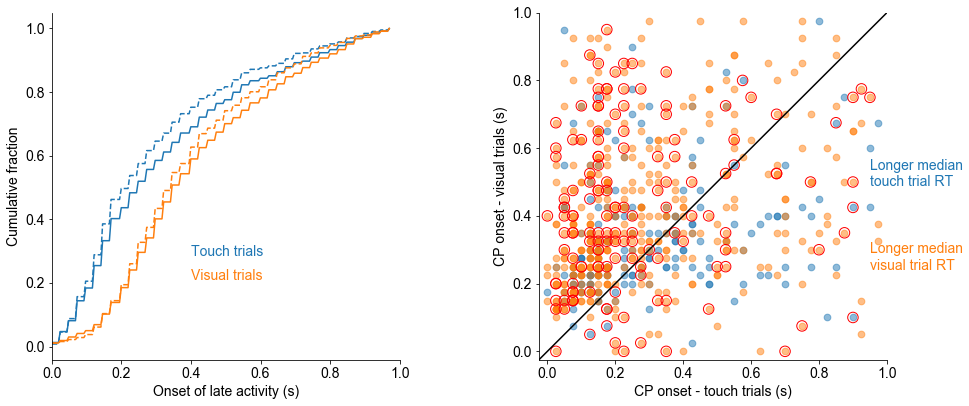

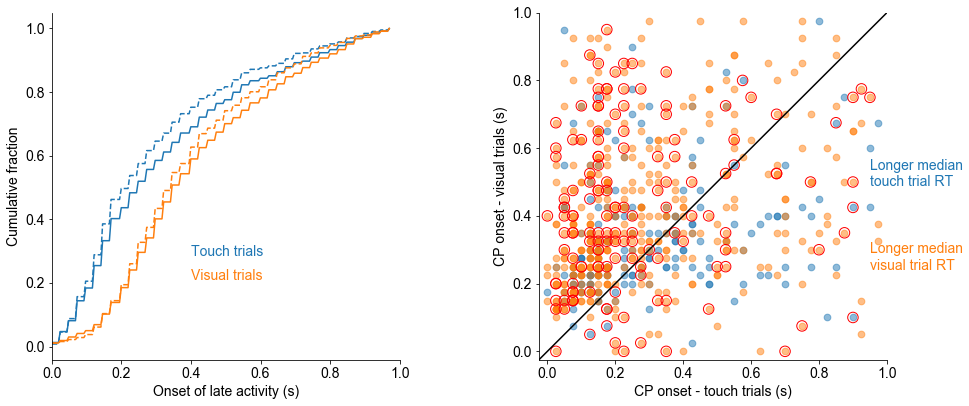

In [42]:
mpl.close('all')
fig4_1 = mpl.figure(figsize = (16*size_mult,7.09*size_mult))
fig4_1.subplots_adjust(bottom = 0.2, wspace = 0.4, hspace = 0.4, right = 0.85)
ax1 = fig4_1.add_subplot(1,2,1)
ax2 = fig4_1.add_subplot(1,2,2)

ax2.scatter(bimodal_lick_units.loc[tac_RT_longer,'Tac_late_onset'], 
           bimodal_lick_units.loc[tac_RT_longer, 'Vis_late_onset'], color = 'C0', s = 45*size_mult*size_mult, alpha = 0.5)
ax2.scatter(bimodal_lick_units.loc[vis_RT_longer,'Tac_late_onset'], 
            bimodal_lick_units.loc[vis_RT_longer, 'Vis_late_onset'], color = 'C1', s = 45*size_mult*size_mult, alpha = 0.5)

ax2.scatter(bimodal_lick_units.loc[sig_diff_RT_idx,'Tac_late_onset'], 
            bimodal_lick_units.loc[sig_diff_RT_idx, 'Vis_late_onset'], 
            facecolors='none', edgecolors='r', s = 110*size_mult*size_mult)

ax2.plot([-0.025,1], [-0.025,1], color = 'k')

ax2.set_xlabel('CP onset - touch trials (s)')
ax2.set_ylabel('CP onset - visual trials (s)')

ax2.text(.95, .5, "Longer median\ntouch trial RT",transform=ax2.transAxes, color = 'C0')
ax2.text(.95, .26, "Longer median\nvisual trial RT",transform=ax2.transAxes, color = 'C1')

colors = ['C0', 'C1']
unimodal = [touch_and_bimodal, visual_and_bimodal]
for i,col in enumerate(['Tac_late_onset','Vis_late_onset']):
    values, base = np.histogram(bimodal_lick_units.loc[:, col], bins=200)
    cumulative = np.cumsum(values)/len(bimodal_lick_units.loc[:, col])
    ax1.plot(base[:-1], cumulative,  '--', color = colors[i%2])
    
    values, base = np.histogram(unimodal[i].loc[:, col], bins=200)
    cumulative = np.cumsum(values)/len(unimodal[i].loc[:, col])
    ax1.plot(base[:-1], cumulative, color = colors[i%2])
ax1.set_xlim([0,1])

ax1.set_ylabel('Cumulative fraction')
ax1.set_xlabel('Onset of late activity (s)')

ax1.text(.4, .3, "Touch trials",transform=ax1.transAxes, color = 'C0')
ax1.text(.4, .23, "Visual trials",transform=ax1.transAxes, color = 'C1')

ax2.set_ylim(-0.025,1)
ax2.set_xlim(-0.025,1)
for ax in [ax1,ax2]:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
fig4_1

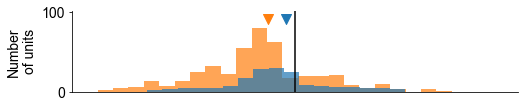

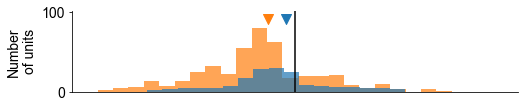

In [43]:

mpl.close('all')
fig4_2 = mpl.figure(figsize = (8*size_mult,1.5*size_mult))
proj_tac_long_RT = (bimodal_lick_units.loc[tac_RT_longer,'Tac_late_onset']-
                    bimodal_lick_units.loc[tac_RT_longer,'Vis_late_onset'])*np.sqrt(2)

proj_vis_long_RT = (bimodal_lick_units.loc[vis_RT_longer,'Tac_late_onset']-
                    bimodal_lick_units.loc[vis_RT_longer,'Vis_late_onset'])*np.sqrt(2)

proj_tac_long_hist = np.histogram(proj_tac_long_RT, bins = 25)
proj_vis_long_hist = np.histogram(proj_vis_long_RT, bins = 25)

ax = fig4_2.add_subplot(111)

ax.bar(proj_vis_long_hist[1][0:-1], proj_vis_long_hist[0],
       (proj_vis_long_hist[1][-1]-proj_vis_long_hist[1][0])/25, color = 'C1',alpha = 0.7)
ax.bar(proj_tac_long_hist[1][0:-1], proj_tac_long_hist[0],
       (proj_tac_long_hist[1][-1]-proj_tac_long_hist[1][0])/25, color = 'C0', alpha =0.7)
ymax = ax.get_ylim()[1] * 1.2
ax.plot([0,0], [0,ymax], color = 'k')
ax.set_ylim(0,ymax)
ax.set_xlim(-np.sqrt(2),np.sqrt(2))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# ax.spines['bottom'].set_visible(False)
ax.scatter(np.mean(proj_tac_long_RT), ymax*0.9, marker = 'v', s = 100*size_mult)
ax.scatter(np.mean(proj_vis_long_RT), ymax*0.9, marker = 'v', s = 100*size_mult, color = 'C1')

ax.set_ylabel('Number\nof units')
ax.axes.get_xaxis().set_visible(False)
fig4_2   


In [ ]:
np.sqrt(40.513**2+40.513**2)

In [ ]:
# fig4_1.savefig('fig4_1.pdf', format='pdf', dpi=900, transparent = True)
# fig4_2.savefig('fig4_2.pdf', format='pdf', dpi=900, transparent = True)

In [44]:
tac_slope, tac_int, tac_r, _, _ = scipy.stats.linregress(touch_and_bimodal.loc[:,'RT_median_TLR'],
                                                         touch_and_bimodal.loc[:, 'Tac_late_onset'])
vis_slope, vis_int, vis_r, _, _ = scipy.stats.linregress(visual_and_bimodal.loc[:,'RT_median_VLL'],
                                                         visual_and_bimodal.loc[:, 'Vis_late_onset'])

x = [0.3, 1]
tac_fitline_values = [tac_slope * i + tac_int for i in x]
vis_fitline_values = [vis_slope * i + vis_int for i in x]

bimodal_lick_units['median_diff'] = bimodal_lick_units['RT_median_TLR'] - bimodal_lick_units['RT_median_VLL']
bimodal_lick_units['RT_index'] =  ((bimodal_lick_units['RT_median_TLR'] - bimodal_lick_units['RT_median_VLL'])/
                            (bimodal_lick_units['RT_median_TLR'] + bimodal_lick_units['RT_median_VLL']))
bimodal_lick_units['late_onset_diff'] = bimodal_lick_units['Tac_late_onset'] - bimodal_lick_units['Vis_late_onset']

bimodal_lick_units_RTsort = bimodal_lick_units.sort_values(['median_diff']).reset_index(drop=True)

diff_slope2, diff_int2, vis_r2, _, _ = scipy.stats.linregress(bimodal_lick_units.loc[:,'median_diff'],
                                                           bimodal_lick_units.loc[:, 'late_onset_diff'])
x2 = [-0.7, .3]
median_diff_fitline_values = [diff_slope2 * i + diff_int2 for i in x2]


In [45]:
mpl.close('all')
import random as rand
def cp_rt_corr(modality = 'touch', **kwargs):
    fig = mpl.figure(figsize = (7*size_mult,7*size_mult))
    gs1 = gridspec.GridSpec(1,1)
    gs2 = gridspec.GridSpec(1,1)
    gs3 = gridspec.GridSpec(1,1)
    
    gs1.update(left = 0.2, right = 0.66, bottom = 0.2, top = 0.66)
    gs2.update(left = 0.2, right = 0.66, bottom = 0.76, top = .9)
    gs3.update(left = 0.76, right = .9, bottom = 0.2, top = 0.66)

    ax1 = mpl.subplot(gs1[0,0])
    ax2 = mpl.subplot(gs2[0,0])
    ax3 = mpl.subplot(gs3[0,0])    

    range = [0,1]
    if modality == 'touch':
        rt = touch_and_bimodal.loc[:, 'RT_median_TLR']
        cp = touch_and_bimodal.loc[:,'Tac_late_onset']
        color = 'C0'
        xvals = x
        yvals = tac_fitline_values
        xlabel = 'Median reaction time (s)\ntouch trials'
        ylabel = 'Onset of late activity (s)\ntouch trials'
        r = tac_r
    elif modality == 'visual':
        rt = visual_and_bimodal.loc[:,'RT_median_VLL']
        cp = visual_and_bimodal.loc[:, 'Vis_late_onset']
        color = 'C1'
        xvals = x
        yvals = vis_fitline_values
        xlabel = 'Median reaction time (s)\nvisual trials'
        ylabel = 'Onset of late activity (s)\nvisual trials'
        r = vis_r
    elif modality == 'diff':
        rt = bimodal_lick_units['median_diff']
        cp = bimodal_lick_units['late_onset_diff']
        color = 'C6'
        xvals = x2
        yvals = median_diff_fitline_values
        xlabel = 'Median reaction time\ndifference (s)'
        ylabel = 'Late-activity\nonset difference'
        r= vis_r2
    elif modality == 'custom':
        rt = bimodal_lick_units.loc[:, 'RT_mean_TLR']
        cp = bimodal_lick_units.loc[:, 'max_tac']
        color = 'b'
        xvals = x
        yvals = x
        xlabel = 'Median reaction time (s)\ntouch trials'
        ylabel = 'peak of CP (s)\ntouch trials'
        r= vis_r2

    rt_count = np.histogram(rt, bins = np.arange(rt.min()+0.001, rt.max()+0.001,0.025))
    rt_med = rt.median()
    
    cp_count = np.histogram(cp, bins = np.arange(cp.min()+0.001, cp.max()+0.001,0.025))
    cp_med = cp.median()
    
    ax1.scatter(rt, cp, alpha = 0.4, color = color, s = 20*size_mult)
    ax1.plot(xvals, yvals, 'k')
    
    ax2.bar(rt_count[1][0:-1], rt_count[0]/len(rt), 0.025, color = color)
    ax2.plot([rt_med]*2, [0,.15], 'r')
    
    ax3.barh(cp_count[1][0:-1], cp_count[0]/len(cp), 0.025, color = color)
    ax3.plot([0,.15], [cp_med]*2, 'r')
    
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    ax1.text(.05, 0.98, "r$^2$ = "+str(np.around(r**2, 2)) , transform=ax1.transAxes, color = 'k')
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.xaxis.set_ticks_position('bottom')
    ax1.yaxis.set_ticks_position('left')
    
    ax2.set_xticklabels([])
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.set_ylabel('Fraction')
    ax2.set_ylim(0,0.15)
    
    ax3.set_yticklabels([])
#     ax3.spines['left'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.set_xlabel('Fraction')
    ax3.set_xlim(0,0.15)

    if modality != 'diff':
        ax1.set_xlim(-0.025,1.2); ax1.set_ylim(-0.025,1.2)
        ax2.set_xlim(-0.025,1.2); ax3.set_ylim(-0.025,1.2)
        
    else:
        ax1.set_xlim(-1,0.75)
        ax1.set_ylim(-1,0.75)
        ax2.set_xlim(-1,0.75)
        ax3.set_ylim(-1,0.75)
       
    return fig

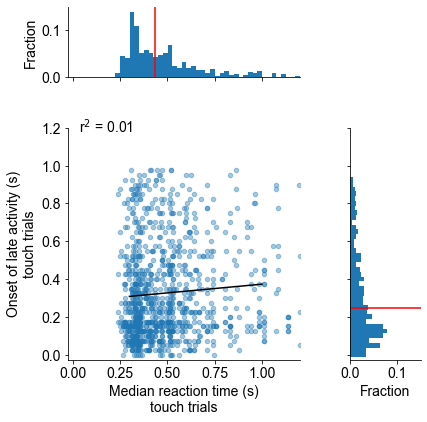

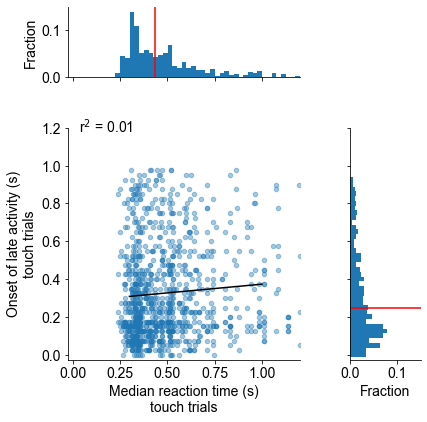

In [46]:
fig4_3 = cp_rt_corr(modality = 'touch')
fig4_3

In [ ]:
fig4_4 = cp_rt_corr(modality = 'visual')
fig4_4

In [ ]:
fig4_5 = cp_rt_corr(modality = 'diff')
fig4_5

In [ ]:
fig4_3.savefig('fig4_3.pdf', format='pdf', dpi=900, transparent = True)
fig4_4.savefig('fig4_4.pdf', format='pdf', dpi=900, transparent = True)
fig4_5.savefig('fig4_5.pdf', format='pdf', dpi=900, transparent = True)